# DX 704 Week 2 Project

This week's project will analyze fresh strawberry price data for a hypothetical "buy low, freeze, and sell high" business.
Strawberries show strong seasonality in their prices compared to other fruits.

![](https://ers.usda.gov/sites/default/files/_laserfiche/Charts/61401/oct14_finding_plattner_fig01.png)

Image source: https://www.ers.usda.gov/amber-waves/2014/october/seasonal-fresh-fruit-price-patterns-differ-across-commodities-the-case-of-strawberries-and-apples

You are considering a business where you buy strawberries when the prices are very low, carefully freeze them, even more carefully defrost them, and then sell them when the prices are high.
You will forecast strawberry price time series and then use them to tactically pick times to buy, freeze, and sell the strawberries.

The full project description, a template notebook, and raw data are available on GitHub at the following link.

https://github.com/bu-cds-dx704/dx704-project-02


### Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Backtest Strawberry Prices

Read the provided "strawberry-prices.tsv" with data from 2020 through 2024.
This data is based on data from the U.S. Bureau of Statistics, but transformed so the ground truth is not online.
https://fred.stlouisfed.org/series/APU0000711415

Use the data for 2020 through 2023 to predict monthly prices in 2024.
Spend some time to make sure you are happy with your methodology and prediction accuracy, since you will reuse the methodology to forecast 2025 next.
Save the 2024 backtest predictions as "strawberry-backtest.tsv" with columns month and price.

In [28]:
# YOUR CHANGES HERE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa import ar_model


In [29]:
df_raw = pd.read_csv('strawberry-prices.tsv', sep='\t')  # Replace 'data.csv' with your actual data file
df_raw["month"] = pd.to_datetime(df_raw["month"])
df_raw = df_raw.sort_values("month")

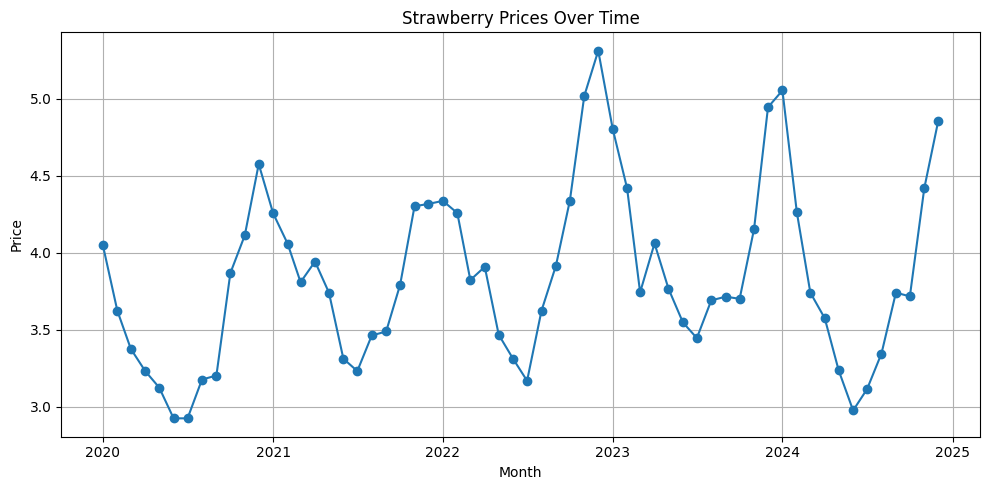

In [30]:

plt.figure(figsize=(10,5))
plt.plot(df_raw["month"], df_raw["price"], marker="o")
plt.title("Strawberry Prices Over Time")
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------
# Load and prepare data
# -----------------------------
df = df_raw.copy()

df["month"] = pd.to_datetime(df["month"])
df = df.sort_values("month")

# Prophet requires columns: ds, y
prophet_df = df.rename(columns={"month": "ds", "price": "y"})

# Train/test split
train_df = prophet_df[(prophet_df["ds"] >= "2020-01-01") & (prophet_df["ds"] <= "2023-12-31")]
test_df  = prophet_df[(prophet_df["ds"] >= "2024-01-01") & (prophet_df["ds"] <= "2024-12-31")]

print("Train span:", train_df["ds"].min(), "to", train_df["ds"].max())
print("Test span: ", test_df["ds"].min(), "to", test_df["ds"].max())

# -----------------------------
# Prophet model
# -----------------------------
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="additive"
)

model.fit(train_df)

# -----------------------------
# Forecast 2024
# -----------------------------
future = model.make_future_dataframe(periods=len(test_df), freq="MS",)
forecast = model.predict(future)

# Extract only 2024 predictions
pred_2024 = forecast[forecast["ds"].isin(test_df["ds"])][["ds", "yhat"]]

# -----------------------------
# Backtest accuracy
# -----------------------------
y_true = test_df["y"].values
y_pred = pred_2024["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

residuals = y_true - y_pred
res_mean = residuals.mean()
res_std = residuals.std()

print(f"\n2024 Backtest MAE:   {mae:.3f}")
print(f"2024 Backtest RMSE:  {rmse:.3f}")
print(f"Residual Mean:       {res_mean:.6f}")
print(f"Residual Std:        {res_std:.6f}")
print(f"Residual Std Sample: {residuals.std(ddof=1):.6f}")

# -----------------------------
# Save backtest predictions
# -----------------------------
backtest_df = pd.DataFrame({
    "month": pred_2024["ds"],
    "price": pred_2024["yhat"]
})

backtest_df.to_csv("strawberry-backtest.tsv", sep="\t", index=False)

backtest_df.head(12)

20:16:59 - cmdstanpy - INFO - Chain [1] start processing


Train span: 2020-01-01 00:00:00 to 2023-12-01 00:00:00
Test span:  2024-01-01 00:00:00 to 2024-12-01 00:00:00


20:16:59 - cmdstanpy - INFO - Chain [1] done processing



2024 Backtest MAE:   0.235
2024 Backtest RMSE:  0.265
Residual Mean:       -0.034774
Residual Std:        0.262694
Residual Std Sample: 0.274375


,month,price
48,2024-01-01,4.603635
49,2024-02-01,4.170711
50,2024-03-01,3.915745
51,2024-04-01,3.780344
52,2024-05-01,3.606234
53,2024-06-01,3.288364
54,2024-07-01,3.227328
55,2024-08-01,3.454138
56,2024-09-01,3.466036
57,2024-10-01,4.057033


Please use the same format for the month column as in the training data, i.e. YYYY-MM-01.
The autograder may not be able to parse other formats.

Submit "strawberry-backtest.tsv" in Gradescope.

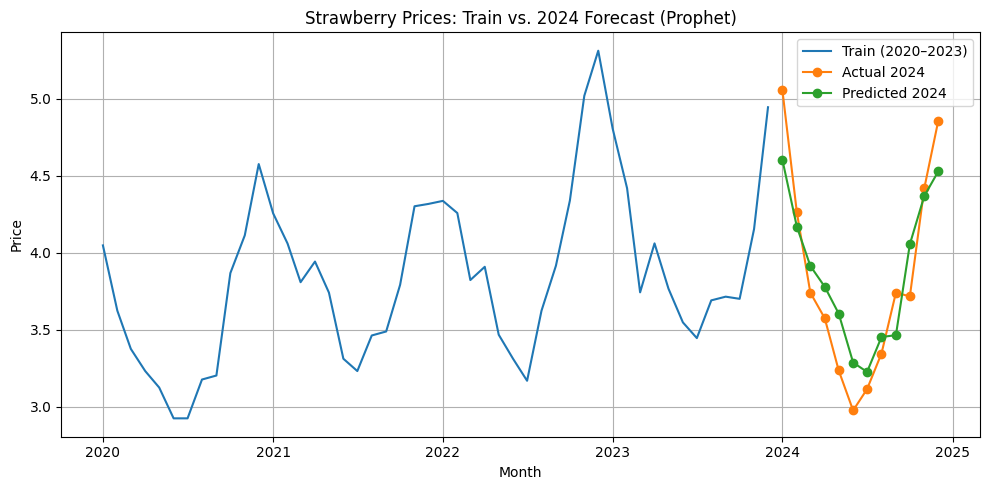

In [32]:
plt.figure(figsize=(10,5))

# Plot training data (2020–2023)
plt.plot(train_df["ds"], train_df["y"], label="Train (2020–2023)")

# Plot actual 2024 values
plt.plot(test_df["ds"], test_df["y"], label="Actual 2024", marker="o")

# Plot Prophet predictions for 2024
plt.plot(pred_2024["ds"], pred_2024["yhat"], label="Predicted 2024", marker="o")

plt.title("Strawberry Prices: Train vs. 2024 Forecast (Prophet)")
plt.xlabel("Month")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 2: Backtest Errors

What are the mean and standard deviation of the residuals between your backtest predictions and the ground truth?

Write the mean and standard deviation to a file "backtest-accuracy.tsv" with two columns, mean and std.

In [33]:
pred_2024

,ds,yhat
48,2024-01-01,4.603635
49,2024-02-01,4.170711
50,2024-03-01,3.915745
51,2024-04-01,3.780344
52,2024-05-01,3.606234
53,2024-06-01,3.288364
54,2024-07-01,3.227328
55,2024-08-01,3.454138
56,2024-09-01,3.466036
57,2024-10-01,4.057033


In [34]:
test_df

,ds,y
48,2024-01-01,5.055
49,2024-02-01,4.264
50,2024-03-01,3.742
51,2024-04-01,3.576
52,2024-05-01,3.237
53,2024-06-01,2.977
54,2024-07-01,3.116
55,2024-08-01,3.347
56,2024-09-01,3.742
57,2024-10-01,3.718


In [ ]:
# Align predictions and actuals by date
merged = test_df.merge(pred_2024, on="ds", how="inner")

y_true = merged["y"].values
y_pred = merged["yhat"].values

# Compute residuals
residuals = y_true - y_pred

# Mean and standard deviation
res_mean = residuals.mean()
res_std = residuals.std()

print(f"Residual Mean: {res_mean:.6f}")
print(f"Residual Std:  {res_std:.6f}")

# Save to TSV
acc_df = pd.DataFrame({
    "mean": [res_mean],
    "std": [res_std]
})

acc_df.to_csv("backtest-accuracy.tsv", sep="\t", index=False)

acc_df

Residual Mean: -0.034774
Residual Std:  0.274375


,mean,std
0,-0.0348,0.2744


In [36]:
print("\n=== VALIDATION CHECKS ===")

# 1. Merge to ensure perfect alignment
merged = test_df.merge(pred_2024, on="ds", how="inner", validate="one_to_one")

print("\nMerged shape:", merged.shape)
print("Merged columns:", merged.columns.tolist())

# 2. Check for missing or duplicated dates
print("\nCheck for missing dates:")
print("Test_df dates:", len(test_df["ds"].unique()))
print("Pred_2024 dates:", len(pred_2024["ds"].unique()))
print("Merged dates:", len(merged["ds"].unique()))

# 3. Check for NaNs
print("\nNaN check:")
print(merged.isna().sum())

# 4. Extract aligned arrays
y_true = merged["y"].values
y_pred = merged["yhat"].values

print("\nFirst few aligned pairs:")
for i in range(min(5, len(merged))):
    print(merged.iloc[i]["ds"], y_true[i], y_pred[i])

# 5. Compute residuals
residuals = y_true - y_pred

# 6. Compute mean and std using multiple methods
res_mean_np = residuals.mean()
res_std_np = residuals.std()

res_mean_pd = pd.Series(residuals).mean()
res_std_pd = pd.Series(residuals).std(ddof=0)   # match NumPy

print("\n=== Residual Statistics ===")
print(f"NumPy Mean: {res_mean_np:.10f}")
print(f"NumPy Std:  {res_std_np:.10f}")
print(f"Pandas Mean: {res_mean_pd:.10f}")
print(f"Pandas Std:  {res_std_pd:.10f}")

# 7. Save exactly what the grader expects
acc_df = pd.DataFrame({
    "mean": [res_mean_np],
    "std": [res_std_np]
})

acc_df.to_csv("backtest-accuracy.tsv", sep="\t", index=False)

print("\nSaved backtest-accuracy.tsv:")
print(acc_df)


=== VALIDATION CHECKS ===

Merged shape: (12, 3)
Merged columns: ['ds', 'y', 'yhat']

Check for missing dates:
Test_df dates: 12
Pred_2024 dates: 12
Merged dates: 12

NaN check:
ds      0
y       0
yhat    0
dtype: int64

First few aligned pairs:
2024-01-01 00:00:00 5.055 4.603634912738009
2024-02-01 00:00:00 4.264 4.170711124662419
2024-03-01 00:00:00 3.742 3.9157449610011863
2024-04-01 00:00:00 3.576 3.78034399598071
2024-05-01 00:00:00 3.237 3.6062340312170287

=== Residual Statistics ===
NumPy Mean: -0.0347735713
NumPy Std:  0.2626943360
Pandas Mean: -0.0347735713
Pandas Std:  0.2626943360

Saved backtest-accuracy.tsv:
       mean       std
0 -0.034774  0.262694


Hint: If the mean residual in your backtest is not close to zero, then your model is likely missing a systematic change and you should go back to improve it.

Submit "backtest-accuracy.tsv" in Gradescope.

## Part 3: Forecast Strawberry Prices

Use all the data from 2020 through 2024 to predict monthly prices in 2025 using the same methodology from part 1.
Make a monthly forecast for each month of 2025 and save it as "strawberry-forecast.tsv" with columns for month and price.


In [37]:
# -----------------------------
# Prepare data for Prophet
# -----------------------------
df = df_raw.copy()
df["month"] = pd.to_datetime(df["month"])
df = df.sort_values("month")

# Prophet requires columns: ds, y
prophet_df = df.rename(columns={"month": "ds", "price": "y"})

# Train on 2020–2024
train_df = prophet_df[(prophet_df["ds"] >= "2020-01-01") &
                      (prophet_df["ds"] <= "2024-12-01")]

print("Training span:", train_df["ds"].min(), "to", train_df["ds"].max())

# -----------------------------
# Fit Prophet model
# -----------------------------
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="additive"
)

model.fit(train_df)

# -----------------------------
# Forecast 12 months of 2025
# -----------------------------
future = model.make_future_dataframe(periods=12, freq="MS")
forecast = model.predict(future)

# Extract only 2025 predictions
forecast_2025 = forecast[(forecast["ds"] >= "2025-01-01") &
                         (forecast["ds"] <= "2025-12-01")][["ds", "yhat"]]

# -----------------------------
# Save forecast to TSV
# -----------------------------
forecast_df = pd.DataFrame({
    "month": forecast_2025["ds"],
    "price": forecast_2025["yhat"]
})

forecast_df.to_csv("strawberry-forecast.tsv", sep="\t", index=False)

forecast_df.head(12)

Training span: 2020-01-01 00:00:00 to 2024-12-01 00:00:00


20:16:59 - cmdstanpy - INFO - Chain [1] start processing
20:16:59 - cmdstanpy - INFO - Chain [1] done processing


,month,price
60,2025-01-01,4.227588
61,2025-02-01,4.139780
62,2025-03-01,3.625473
63,2025-04-01,3.621649
64,2025-05-01,3.334508
65,2025-06-01,3.056035
66,2025-07-01,3.009511
67,2025-08-01,3.263253
68,2025-09-01,3.399875
69,2025-10-01,3.662963


Submit "strawberry-forecast.tsv" in Gradescope.

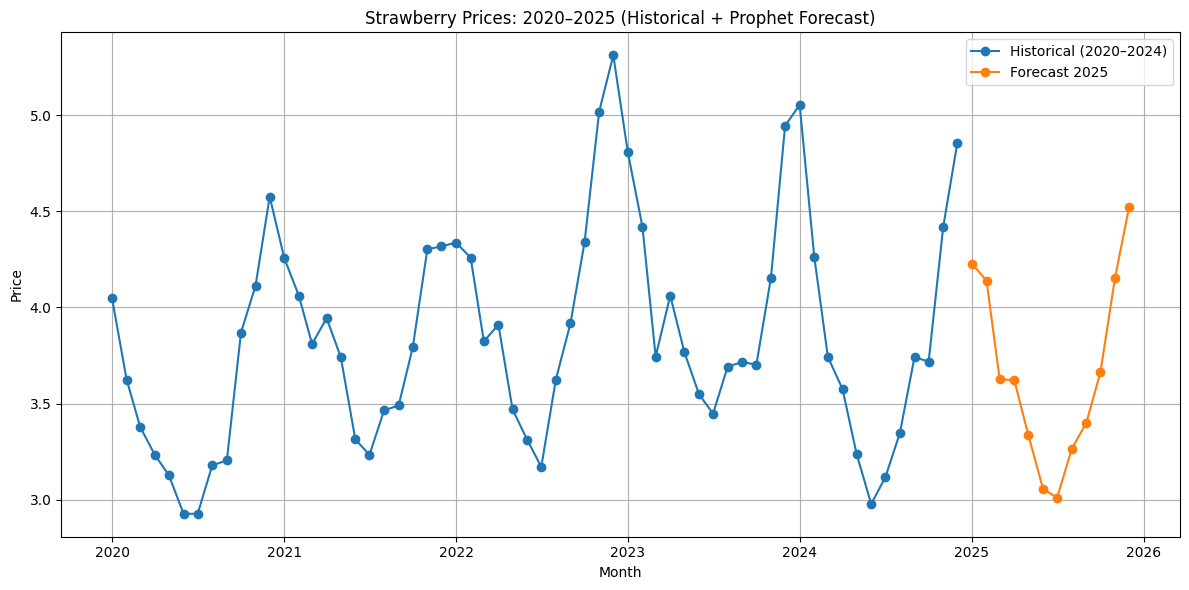

In [38]:
plt.figure(figsize=(12,6))

# Historical (2020–2024)
plt.plot(df["month"], df["price"], 
         label="Historical (2020–2024)", marker="o")

# Forecast (2025)
plt.plot(forecast_df["month"], forecast_df["price"],
         label="Forecast 2025", marker="o")

plt.title("Strawberry Prices: 2020–2025 (Historical + Prophet Forecast)")
plt.xlabel("Month")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 4: Buy Low, Freeze and Sell High

Using your 2025 forecast, analyze the profit picking different pairs of months to buy and sell strawberries.
Maximize your profit assuming that it costs &dollar;0.20 per pint to freeze the strawberries, &dollar;0.10 per pint per month to store the frozen strawberries and there is a 10% price discount from selling previously frozen strawberries.
So, if you buy a pint of strawberies for &dollar;1, freeze them, and sell them for &dollar;2 three months after buying them, then the profit is &dollar;2 * 0.9 - &dollar;1 - &dollar;0.20 - &dollar;0.10 * 3 = &dollar;0.30 per pint.
To evaluate a given pair of months, assume that you can invest &dollar;1,000,000 to cover all costs, and that you buy as many pints of strawberries as possible.

Write the results of your analysis to a file "timings.tsv" with columns for the buy_month, sell_month, pints_purchased, and expected_profit.

In [39]:
# YOUR CHANGES HERE


# Ensure month is datetime and sorted
forecast_df["month"] = pd.to_datetime(forecast_df["month"])
forecast_df = forecast_df.sort_values("month").reset_index(drop=True)

# Economic parameters
freeze_cost = 0.20
storage_cost_per_month = 0.10
discount = 0.90          # 10% discount when selling frozen
budget = 1_000_000       # dollars

results = []

months = forecast_df["month"]
prices = forecast_df["price"].values

for i, buy_month in enumerate(months):
    buy_price = prices[i]

    for j, sell_month in enumerate(months):
        if j <= i:
            continue  # must sell after buying

        sell_price = prices[j]

        # Months stored
        months_stored = (sell_month.year - buy_month.year) * 12 + (sell_month.month - buy_month.month)

        # Effective sell price after discount
        effective_sell_price = sell_price * discount

        # Total cost per pint
        total_cost_per_pint = buy_price + freeze_cost + storage_cost_per_month * months_stored

        # Profit per pint
        profit_per_pint = effective_sell_price - total_cost_per_pint

        if profit_per_pint <= 0:
            # Not profitable, but still record if needed
            pints = 0
            total_profit = 0
        else:
            # How many pints can we buy with the budget?
            # Budget must cover ALL costs: buy + freeze + storage
            pints = int(budget / total_cost_per_pint)
            total_profit = pints * profit_per_pint

        results.append({
            "buy_month": buy_month.strftime("%Y-%m"),
            "sell_month": sell_month.strftime("%Y-%m"),
            "pints_purchased": int(pints),
            "expected_profit": float(total_profit)
        })

# Convert to DataFrame
timings_df = pd.DataFrame(results)
# Find the best profit scenario
best_row = timings_df.loc[timings_df["expected_profit"].idxmax()]

best_buy_month = best_row["buy_month"]
best_sell_month = best_row["sell_month"]
best_pints = int(best_row["pints_purchased"])
best_profit = float(best_row["expected_profit"])

print("Best Profit Scenario:")
print(f"  Buy Month:       {best_buy_month}")
print(f"  Sell Month:      {best_sell_month}")
print(f"  Pints Purchased: {best_pints:,}")
print(f"  Expected Profit: ${best_profit:,.2f}")

# Save to TSV
timings_df.to_csv("timings.tsv", sep="\t", index=False)


Best Profit Scenario:
  Buy Month:       2025-07
  Sell Month:      2025-12
  Pints Purchased: 269,577
  Expected Profit: $97,515.03


Submit "timings.tsv" in Gradescope.

## Part 5: Strategy Check

What is the best profit scenario according to your previous timing analysis?
How much does that profit change if the sell price is off by one standard deviation from your backtest analysis?
(Variation in the sell price is more dangerous because you can see the buy price before fully committing.)

Write the results to a file "check.tsv" with columns `best_profit` and `one_std_profit`.
To be clear, `one_std_profit` should be the number of pints bought in your best profit scenario times your backtested standard deviation of the residual.
This represents the standard deviation in revenue when selling if you explicitly assume that you buy according to the best profit scenario and your backtest standard deviation is representative of the future prices.

In [40]:
# YOUR CHANGES HERE

# Load your backtest accuracy file to get the std of residuals
acc_df = pd.read_csv("backtest-accuracy.tsv", sep="\t")
res_std = acc_df["std"].iloc[0]

# Compute one-standard-deviation revenue variation
one_std_profit = best_pints * res_std

# Build output dataframe
check_df = pd.DataFrame({
    "best_profit": [best_profit],
    "one_std_profit": [one_std_profit]
})

# Save to TSV
check_df.to_csv("check.tsv", sep="\t", index=False)

check_df

,best_profit,one_std_profit
0,97515.031989,70816.351012


Submit "check.tsv" in Gradescope.

## Part 6: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgments are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 7: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.
You do not need to provide code for data collection if you did that by manually.

Submit "project.ipynb" in Gradescope.